In [1]:
from romatch import roma_outdoor
import torch

imA_path = 'project_data/data/1/kronan1.JPG'
imB_path = 'project_data/data/1/kronan2.JPG'

H_A  =1296
W_A = 1936
H_B = 1296
W_B = 1936

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
roma_model = roma_outdoor(device=device)

/home/davnords/python-envs/main/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davnords/python-envs/main/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)


In [7]:
warp, certainty = roma_model.match(imA_path, imB_path, device=device)
matches, certainty = roma_model.sample(warp, certainty)
kptsA, kptsB = roma_model.to_pixel_coordinates(matches, H_A, W_A, H_B, W_B)
kptsA, kptsB = kptsA.cpu().numpy(), kptsB.cpu().numpy()

In [11]:
from utils.get_dataset_info import get_dataset_info
from utils import general, pflat, estimate_E_robust
import cv2 as cv
import numpy as np
dataset = 1
K, img_names, init_pair, pixel_threshold = get_dataset_info(dataset)
K_inv = np.linalg.inv(K)
eps = pixel_threshold * 2 / ( K[0,0] + K[1 ,1])

x1u = general.make_homogenous(kptsA)
x2u = general.make_homogenous(kptsB)

x1n = pflat.pflat(K_inv @ x1u)
x2n = pflat.pflat(K_inv @ x2u)

E, inliers = estimate_E_robust.estimate_E_robust(x1n, x2n, eps, iterations=100)

RANSAC iterations: 100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s]

After running RANSAC for 1000 iterations the best solution has 9735 inliers of 10000 points. I.e. c. 97.35%


Camera 1 has 0.00% points in front of both cameras


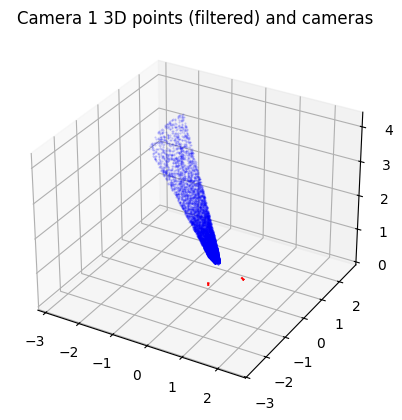

Camera 2 has 0.00% points in front of both cameras


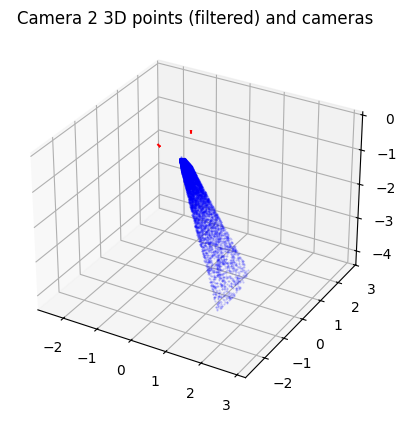

Camera 3 has 100.00% points in front of both cameras


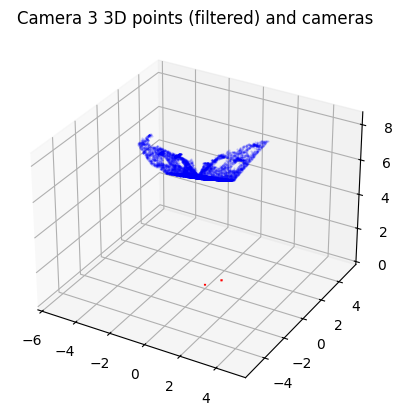

Camera 4 has 0.00% points in front of both cameras


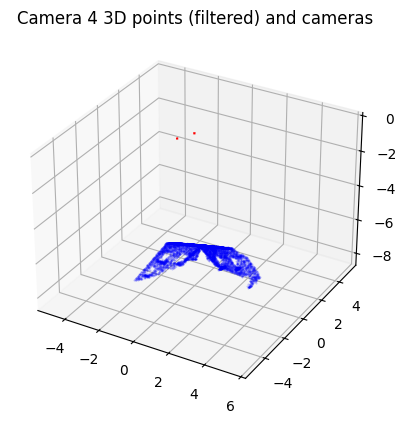

In [14]:
from utils.extract_P_from_E import extract_P_from_E
from utils.triangulate_3D_point_DLT import triangulate_3D_point_DLT
from matplotlib import pyplot as plt
from utils.plotcams import plotcams

P1 = np.hstack((np.eye(3), np.zeros((3,1))))
P2s = extract_P_from_E(E)

xn = np.array([x1n, x2n])

N = x1u.shape[-1]
camera_counter = 1

for P2 in P2s:
    Xj = []
    positive_depth_count = 0
    for i in range(N):
        xi = xn[:, :, i]
        Xi, _ = triangulate_3D_point_DLT(xi[0, :2], xi[1, :2], P1, P2)
        Xj.append(Xi)

        X_h = np.hstack((Xi, [1]))  # Homogeneous coordinates
        if P1[2, :] @ X_h > 0 and P2[2, :] @ X_h > 0:
            positive_depth_count += 1

    print(f"Camera {camera_counter} has {positive_depth_count/N*100:.2f}% points in front of both cameras")
    Xj = np.array(Xj)

    # Compute distances from the origin
    distances = np.linalg.norm(Xj, axis=1)

    # Find the 90th percentile distance
    threshold = np.percentile(distances, 90)

    # Filter out points beyond the threshold
    Xj_filtered = Xj[distances <= threshold]

    # Plot the filtered points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Xj_filtered[:, 0], Xj_filtered[:, 1], Xj_filtered[:, 2], 'bo', alpha=0.2, markersize=0.5)
    plotcams([P1, P2], ax=ax, scale=0.1)
    plt.axis('equal')
    plt.title(f"Camera {camera_counter} 3D points (filtered) and cameras")
    plt.savefig(f"plots/compEx2_plot{2+camera_counter}_filtered.png")
    plt.show()
    plt.close()

    camera_counter += 1